In [5]:
import pandas as pd
import jsonstat as jstat
from dfply import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

base_url = 'http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/'
base_url_1 = 'nrg_100a?precision=1&sinceTimePeriod=2000&unit=KTOE&indic_nrg=B_100900&'

In [6]:
# specify country, time here
country = 'UK'
year = '2016'

In [7]:
geos = [country]
url = "".join(list(map(lambda t: "geo={}&".format(t), geos)))[:-1]

# url2 = "".join(list(map(lambda t: "product={}&".format(t), agg_lvls[1])))[:-1]


full_url = base_url + base_url_1 + url
print(full_url)

http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/nrg_100a?precision=1&sinceTimePeriod=2000&unit=KTOE&indic_nrg=B_100900&geo=UK


In [8]:
data = jstat.from_url(full_url)
data_df = data.to_data_frame('time', content='id')
data_df.head()

,unit,product,indic_nrg,geo,Value
time,,,,,
2000,KTOE,0000,B_100900,UK,230559.9
2001,KTOE,0000,B_100900,UK,231704.5
2002,KTOE,0000,B_100900,UK,229033.0
2003,KTOE,0000,B_100900,UK,233741.6
2004,KTOE,0000,B_100900,UK,232601.1


In [5]:
data_df.reset_index(level=0,inplace=True)

In [6]:
data_df['product'].unique()

array(['0000', '2000', '3000', '4000', '5100', '5200', '5500', '6000',
       '7200'], dtype=object)

In [7]:
data_df = data_df[data_df['product'].str.len() <= 4]
data_df['lv3'] = data_df['product'].str[:3]
data_df['lv2'] = data_df['product'].str[:2]
data_df.head()

,time,unit,product,indic_nrg,geo,Value,lv3,lv2
0,2000,KTOE,0000,B_100900,UK,230559.9,000,00
1,2001,KTOE,0000,B_100900,UK,231704.5,000,00
2,2002,KTOE,0000,B_100900,UK,229033.0,000,00
3,2003,KTOE,0000,B_100900,UK,233741.6,000,00
4,2004,KTOE,0000,B_100900,UK,232601.1,000,00


In [8]:
data_df['category'] = data_df['lv2']
data_df.loc[data_df['lv2'] == '55','category'] = data_df['lv3']
data_df.head()

,time,unit,product,indic_nrg,geo,Value,lv3,lv2,category
0,2000,KTOE,0000,B_100900,UK,230559.9,000,00,00
1,2001,KTOE,0000,B_100900,UK,231704.5,000,00,00
2,2002,KTOE,0000,B_100900,UK,229033.0,000,00,00
3,2003,KTOE,0000,B_100900,UK,233741.6,000,00,00
4,2004,KTOE,0000,B_100900,UK,232601.1,000,00,00


In [9]:
pie_data = (data_df >> mask(X.geo == country, X.time == year, X.category != '00'))
pie_data = (pie_data >> group_by('category') >> summarize(total = X.Value.sum()))
# total_sum = sum(albania['Value'])

# lv2['category'] = lv2['product']
# lv2.loc[(lv2['Value'] / total_sum) < 0.05,'category'] = 'Other'


pie_data.sort_values(by=['total'],ascending=False)

,category,total
1,30,71403.9
2,40,69553.8
3,51,18502.0
5,550,15362.1
0,20,11763.3
6,60,1508.7
7,72,1346.1
4,52,0.0


In [10]:
# translation
trans = {
    "40": "Gas",
    "554": "Biomass",
    "30": "Total petroleum",
    "51": "Nuclear",
    "552": "Wind",
    "553": "Solar",
    "551": "Hydro",
    "22": "Lignite and Derivatives",
    "60": "Electric energy",
    "20": "Solid fuels",
    "550": "RES"
}
# trans['41']

def trans_(x):
    try:
        return trans[x]
    except KeyError:
        return 'Other'

pie_data['cn'] = pie_data['category'].apply(lambda x: trans_(x))

In [11]:
# plot = go.Pie(
#     values = pie_data['total'],
#     labels = pie_data['cn'],
#     name = 'AL'
# )

fig = {
    "data": [{
            'labels': pie_data['cn'],
            'values': pie_data['total'],
            'type': 'pie',
            'hoverinfo':'label+percent',
            'hole': .4
        }],
    'layout': {'title': 'Gross inland consumption in {}, {}'.format(country, year)}
}

iplot(fig, show_link=False)

In [12]:
csv_data = (pie_data >> group_by('cn') >> summarize(total = X.total.sum())) 
csv_data.to_csv("primary_production_yearly_{}_{}.csv".format(country, year),index=False)

In [13]:
## further disaggregation of RES

base_url_1 = 'nrg_107a?precision=1&sinceTimePeriod=2000&unit=KTOE&indic_nrg=B_100900&'
full_url = base_url + base_url_1 + url
print(full_url)

http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/nrg_107a?precision=1&sinceTimePeriod=2000&unit=KTOE&indic_nrg=B_100900&geo=UK


In [14]:
RES_data = jstat.from_url(full_url)
RES_df = RES_data.to_data_frame('time', content='id')
RES_df.reset_index(level=0,inplace=True)
RES_df.head()

,time,unit,product,indic_nrg,geo,Value
0,2000,KTOE,5500,B_100900,UK,2263.8
1,2001,KTOE,5500,B_100900,UK,2274.7
2,2002,KTOE,5500,B_100900,UK,2524.0
3,2003,KTOE,5500,B_100900,UK,2705.0
4,2004,KTOE,5500,B_100900,UK,3242.3


In [15]:
print(RES_df['product'].unique())
RES_df = RES_df[~RES_df['product'].isin(['5500','5540','5546','5547','5548','5549'])]
print(RES_df['product'].unique())

RES_df.loc[RES_df['product'].isin(['5532','5534']),'product'] = '5530' 

['5500' '5510' '5520' '5532' '5534' '5535' '5540' '5541' '5542' '55431'
 '5544' '5545' '5546' '5547' '5548' '5549' '5550']
['5510' '5520' '5532' '5534' '5535' '5541' '5542' '55431' '5544' '5545'
 '5550']


In [16]:
# create the RES pie data 
pie_data_RES = (RES_df >> mask(X.geo == country, X.time == year))
pie_data_RES = (pie_data_RES >> group_by('product') >> summarize(total = X.Value.sum()))
pie_data_RES['product'] = pie_data_RES['product'].str.replace('0','')

pie_data_RES.sort_values(by=['total'],ascending=False)

,product,total
4,5541,6370.1
1,552,3213.0
5,5542,2600.9
2,553,947.2
8,5545,945.9
6,55431,820.4
0,551,463.9
9,555,0.8
3,5535,0.0
7,5544,0.0


In [17]:
pie_data.sort_values(by=['total'],ascending=False)

,category,total,cn
1,30,71403.9,Total petroleum
2,40,69553.8,Gas
3,51,18502.0,Nuclear
5,550,15362.1,RES
0,20,11763.3,Solid fuels
6,60,1508.7,Electric energy
7,72,1346.1,Other
4,52,0.0,Other


In [18]:
# translation
# ['551' '552' '553' '5535' '5541' '5542' '55431' '5544' '5545' '5550']

trans = {
    "40": "Gas",
    "554": "Biomass",
    "30": "Total petroleum",
    "51": "Nuclear",
    "552": "Wind",
    "553": "Solar",
    "551": "Hydro",
    "22": "Lignite and Derivatives",
    "60": "Electric energy",
    "20": "Solid fuels",
    "550": "RES",
    "5535": "Tide, wave",
    "5541": "Solid biofuels (excl charcoal)",
    "5542": "Biogas",
    "55431": "Renewable waste",
    "5544": "Charcoal",
    "5545": "Liquid biofuels",
    "555": "Geothermal"
}

pie_data_RES['cn'] = pie_data_RES['product'].apply(lambda x: trans_(x))
pie_data_RES.head()

,product,total,cn
0,551,463.9,Hydro
1,552,3213.0,Wind
2,553,947.2,Solar
3,5535,0.0,"Tide, wave"
4,5541,6370.1,Solid biofuels (excl charcoal)


In [19]:
final_data = (pie_data >> drop('category') >> mutate(RES = False))[pie_data['cn'] != 'RES'].append((pie_data_RES >> mutate(RES = True) >> drop('product')))

final_data_a = (final_data >> 
 mutate(sh = X.total / X.total.sum()) >> 
 mutate(oth = X.sh < 0.01)
)

final_data_a.loc[final_data_a['cn'] == 'Other','oth'] = True
final_data_a.loc[(final_data_a['RES'] == True) & (final_data_a['oth'] == True),'cn'] = 'Other RES'
final_data_a.loc[(final_data_a['RES'] == False) & (final_data_a['oth'] == True),'cn'] = 'Other Non-RES'
final_data_a = (final_data_a >> group_by('cn') >> summarize(total = X.total.sum(), sh = X.sh.sum()))

In [20]:
final_data_a.sort_values(by=['total'],ascending=False)

,cn,sh,total
7,Total petroleum,0.376921,71403.9
1,Gas,0.367155,69553.8
2,Nuclear,0.097667,18502.0
6,Solid fuels,0.062095,11763.3
5,Solid biofuels (excl charcoal),0.033626,6370.1
8,Wind,0.016961,3213.0
4,Other RES,0.016777,3178.2
3,Other Non-RES,0.015070,2854.8
0,Biogas,0.013729,2600.9


In [22]:
fig = {
    "data": [{
            'labels': final_data_a['cn'],
            'values': final_data_a['total'],
            'type': 'pie',
            'hoverinfo':'label+percent',
            'hole': .4
        }],
    'layout': {'title': 'Gross inland consumption in {}, {}'.format(country, year)}
}

iplot(fig, show_link=False)

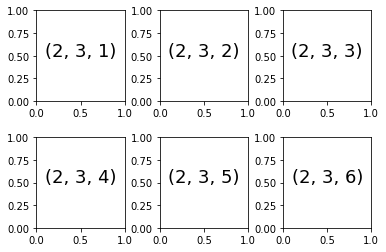

In [27]:
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    xaxis=dict(
        domain=[0, 0.45]
    ),
    yaxis=dict(
        domain=[0, 0.45]
    ),
    xaxis2=dict(
        domain=[0.55, 1]
    ),
    xaxis3=dict(
        domain=[0, 0.45],
        anchor='y3'
    ),
    xaxis4=dict(
        domain=[0.55, 1],
        anchor='y4'
    ),
    yaxis2=dict(
        domain=[0, 0.45],
        anchor='x2'
    ),
    yaxis3=dict(
        domain=[0.55, 1]
    ),
    yaxis4=dict(
        domain=[0.55, 1],
        anchor='x4'
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='multiple-subplots')